### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings, Random, Dierckx, DelimitedFiles
using Interpolations
include("STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("STG_models.jl") # Loading of STG model
include("STG_utils.jl") # Loading of some utils functions
include("STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("STG_neuromodulation.jl") # Loading of the neuromodulation cells functions
include("STG_large_simulations.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 300000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1)
default(fmt = :png)

# Moving average function
moving_average(vs, n, padding) = [sum(vs[i:(i+n-1)])/n for i in 1:padding:(length(vs)-(n-1))];

# **Neuromodulation gCaS and gA overall**

## **Computation of gCaS and gA**

In [3]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth);
# create a spiking set with max variability in gCaS and gA

In [4]:
# Definition of parameters
α = 5e-3 # Rate of transfer between intracellular and membrane
β = 5e-3 # Rate of degradation of intracellular proteins
Kp = 3e-4 # Proprtional gain
Ki = 5e-6 # Integral gain
Kt = β / Ki # Anti-windup gain
gsth_sim(t) = 5 - 13 * pulse(t, Tfinal/2, Tfinal) # Reference
guth_sim(t) = 4.
u_maxCaS = 1e7 # Maximum value of actuator
u_maxA = 1e7

# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
tau_Na = 600 # Sodium integral action time constants
Ca_tgt(t) = 125. # Calcium target

# Input current definition
Iapp = 0.

tt = 0. : 0.2 : Tfinal

window_size_s = 5
padding_s = 0.2
window_size_ = Int64(round(window_size_s*1000*length(tt)/(Tfinal)))
padding_ = Int64(round(padding_s*1000*length(tt)/(Tfinal)))
tt_moving_average_ = window_size_s/2 : padding_s : Tfinal/1000 - window_size_s/2
tt_moving_average_plot = range(0, Tfinal/1e3, length(tt_moving_average_));

In [13]:
# gNa_matrix, gCaT_matrix, gCaS_matrix, gA_matrix, gKCa_matrix, gKd_matrix, gH_matrix, 
# gleak_matrix, Ca_ma_matrix = simulate_STG_population(g_all_init, Iapp, tau_Na, tau_g, Ca_tgt,
#                                                      C, α, β, Kp, Ki, Kt, gsth_sim, guth_sim,
#                                                      ICs_th_init, u_maxCaS, u_maxA, tt)

In [14]:
# writedlm("./data/gNa_matrix.dat", gNa_matrix)
# writedlm("./data/gCaT_matrix.dat", gCaT_matrix)
# writedlm("./data/gCaS_matrix.dat", gCaS_matrix)
# writedlm("./data/gA_matrix.dat", gA_matrix)
# writedlm("./data/gKCa_matrix.dat", gKCa_matrix)
# writedlm("./data/gKd_matrix.dat", gKd_matrix)
# writedlm("./data/gH_matrix.dat", gH_matrix)
# writedlm("./data/gleak_matrix.dat", gleak_matrix)
# writedlm("./data/Ca_ma_matrix.dat", Ca_ma_matrix)

In [5]:
gNa_matrix = readdlm("./data/gNa_matrix.dat")
gCaT_matrix = readdlm("./data/gCaT_matrix.dat")
gCaS_matrix = readdlm("./data/gCaS_matrix.dat")
gA_matrix = readdlm("./data/gA_matrix.dat")
gKCa_matrix = readdlm("./data/gKCa_matrix.dat")
gKd_matrix = readdlm("./data/gKd_matrix.dat")
gH_matrix = readdlm("./data/gH_matrix.dat")
gleak_matrix = readdlm("./data/gleak_matrix.dat")
Ca_ma_matrix = readdlm("./data/Ca_ma_matrix.dat");

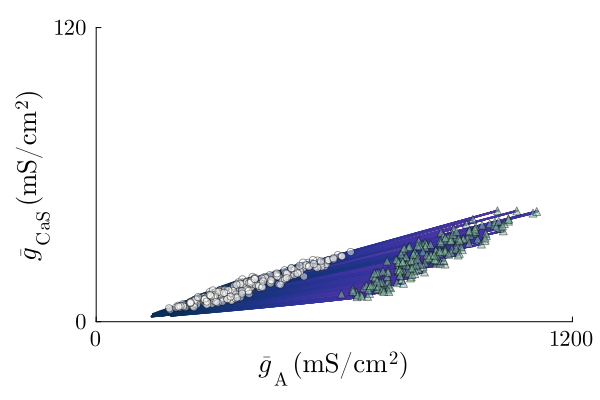

In [9]:
p1 = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
          xticks=([0, 1200], [L"0", L"1200"]), yticks=([0, 120], [L"0", L"120"]))
for i = 1 : ncells
    # Interpolating
    interpA = linear_interpolation(tt[2:5000:Int(round(end/2))]./1e3, gA_matrix[i, 1:Int(end/2)], extrapolation_bc=Line())
    interpCaS = linear_interpolation(tt[2:5000:Int(round(end/2))]./1e3, gCaS_matrix[i, 1:Int(end/2)], extrapolation_bc=Line())

    # Storing
    gA_plot_Ca = interpA(tt_moving_average_plot[1:Int(end/2)])
    gCaS_plot_Ca = interpCaS(tt_moving_average_plot[1:Int(end/2)])
    
    # Plotting
    plot!(gA_plot_Ca, gCaS_plot_Ca, label="", line_z=Ca_ma_matrix[i, 1:Int(end/2)], grid=false, c=:thermal,
          linewidth=2, clim=(0, 500), yguidefontsize=18, xguidefontsize=18, alpha=1)
end

for i = 1 : ncells
    scatter!([gA_matrix[i, 1]], [gCaS_matrix[i, 1]], color=:white, alpha=0.5)
end

for i = 1 : ncells
    scatter!([gA_matrix[i, Int(round(end/2))]], [gCaS_matrix[i, Int(round(end/2))]], 
        color=myGreen, alpha=0.5, marker=:utriangle)
end

xlims!((0, 1200))
ylims!((0, 120))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")

display(p1)
# savefig(p1, "./figures/gCaSgA_spiking.pdf")

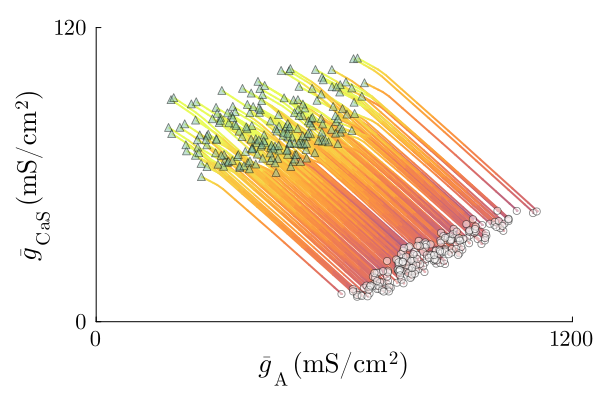

In [11]:
p2 = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
          xticks=([0, 1200], [L"0", L"1200"]), yticks=([0, 120], [L"0", L"120"]))
i_nmodtt = 4
for i = 1 : ncells
    # Interpolating
    interpA = linear_interpolation(tt[Int(round(end/2)):5000:Int(round(end/2))+i_nmodtt*5000]./1e3, gA_matrix[i, Int(end/2):Int(end/2)+i_nmodtt], extrapolation_bc=Line())
    interpCaS = linear_interpolation(tt[Int(round(end/2)):5000:Int(round(end/2))+i_nmodtt*5000]./1e3, gCaS_matrix[i, Int(end/2):Int(end/2)+i_nmodtt], extrapolation_bc=Line())

    # Storing
    t_min_nmod = tt[Int(round(end/2))]
    t_max_nmod = tt[Int(round(end/2))+i_nmodtt*5000]
    i_nmod = findall(tt_moving_average_plot .> t_min_nmod/1e3 .&& tt_moving_average_plot .< t_max_nmod/1e3)
    gA_plot_Ca = interpA(tt_moving_average_plot[i_nmod])
    gCaS_plot_Ca = interpCaS(tt_moving_average_plot[i_nmod])
    
    # Plotting
    plot!(gA_plot_Ca, gCaS_plot_Ca, label="", line_z=Ca_ma_matrix[i, i_nmod], grid=false, c=:thermal,
          linewidth=2, clim=(0, 500), yguidefontsize=18, xguidefontsize=18, alpha=1)
end

for i = 1 : ncells
    scatter!([gA_matrix[i, Int(end/2)]], [gCaS_matrix[i, Int(end/2)]], color=:white, alpha=0.5)
end

for i = 1 : ncells
    scatter!([gA_matrix[i, Int(end/2)+i_nmodtt]], [gCaS_matrix[i, Int(end/2)+i_nmodtt]], 
        color=myGreen, alpha=0.5, marker=:utriangle)
end

xlims!((0, 1200))
ylims!((0, 120))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")

display(p2)
# savefig(p2, "./figures/gCaSgA_nmod.pdf")

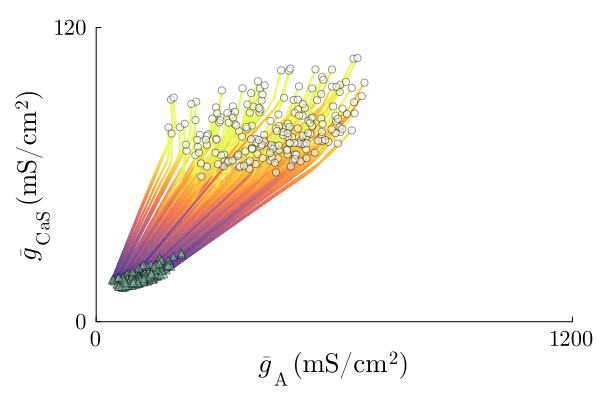

In [14]:
p3 = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
          xticks=([0, 1200], [L"0", L"1200"]), yticks=([0, 120], [L"0", L"120"]))
for i = 1 : ncells
    # Interpolating
    i_nmodtt = 4
    interpA = linear_interpolation(tt[Int(round(end/2))+i_nmodtt*5000:5000:end]./1e3, gA_matrix[i, Int(end/2)+i_nmodtt:end], extrapolation_bc=Line())
    interpCaS = linear_interpolation(tt[Int(round(end/2))+i_nmodtt*5000:5000:end]./1e3, gCaS_matrix[i, Int(end/2)+i_nmodtt:end], extrapolation_bc=Line())

    # Storing
    t_max_nmod = tt[Int(round(end/2))+i_nmodtt*5000]
    i_after = findall(tt_moving_average_plot .> t_max_nmod/1e3)
    gA_plot_Ca = interpA(tt_moving_average_plot[i_after])
    gCaS_plot_Ca = interpCaS(tt_moving_average_plot[i_after])
    
    # Plotting
    plot!(gA_plot_Ca, gCaS_plot_Ca, label="", line_z=Ca_ma_matrix[i, i_after], grid=false, c=:thermal,
          linewidth=2, clim=(0, 500), yguidefontsize=18, xguidefontsize=18, alpha=1)
end

for i = 1 : ncells
    scatter!([gA_matrix[i, Int(end/2)+i_nmodtt]], [gCaS_matrix[i, Int(end/2)+i_nmodtt]], color=:white, alpha=0.5)
end

for i = 1 : ncells
    scatter!([gA_matrix[i, end]], [gCaS_matrix[i, end]], 
        color=myGreen, alpha=0.5, marker=:utriangle)
end

xlims!((0, 1200))
ylims!((0, 120))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")

display(p3)
# savefig(p3, "./figures/gCaSgA_nmod_nocrash.pdf")

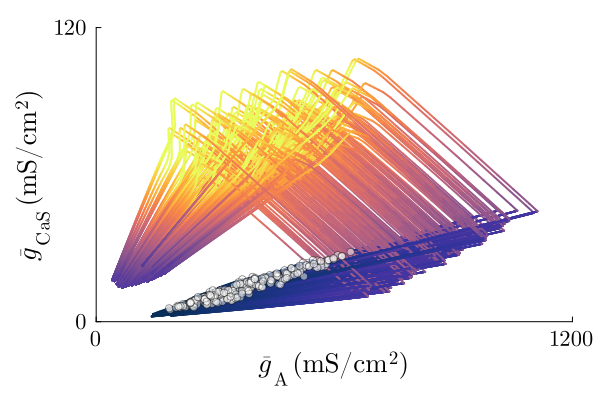

In [16]:
p9 = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
          xticks=([0, 1200], [L"0", L"1200"]), yticks=([0, 120], [L"0", L"120"]))
for i = 1 : ncells
    # Interpolating
    interpA = linear_interpolation(tt[2:5000:end]./1e3, gA_matrix[i, :], extrapolation_bc=Line())
    interpCaS = linear_interpolation(tt[2:5000:end]./1e3, gCaS_matrix[i, :], extrapolation_bc=Line())

    # Storing
    gA_plot_Ca = interpA(tt_moving_average_plot)
    gCaS_plot_Ca = interpCaS(tt_moving_average_plot)
    
    # Plotting
    plot!(gA_plot_Ca, gCaS_plot_Ca, label="", line_z=Ca_ma_matrix[i, :], grid=false, c=:thermal,
          linewidth=2, clim=(0, 500), yguidefontsize=18, xguidefontsize=18, alpha=1)
end

for i = 1 : ncells
    scatter!([gA_matrix[i, 1]], [gCaS_matrix[i, 1]], color=:white, alpha=0.5)
end

xlims!((0, 1200))
ylims!((0, 120))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")

display(p9)
# savefig(p9, "./figures/gCaSgA.pdf")